https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=1min&apikey=B76GBTN7SXNUU3TS&datatype=csv



In [2]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/fuchs/anaconda3/envs/python35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Check python version - should be 3.5.*
from platform import python_version

print(python_version())

3.5.4


In [192]:
# Create network and compile
# Look back is the amount of samples in the past the network takes into consideration
look_back = 10
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

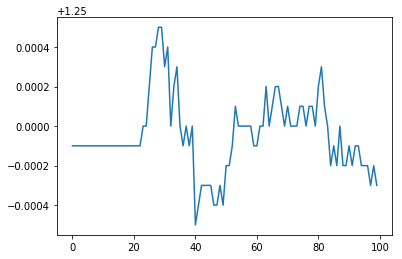

In [202]:
numpy.random.seed(7)
# load dataset
dataframe = read_csv('fxintraday2.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()
# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# do some reshaping
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input 
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [203]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 2/100
56/56 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 3/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 4/100
56/56 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 5/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 6/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 7/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 8/100
56/56 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 9/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 10/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 11/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 12/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0140
Epoch 13/100
56/56 [=================

Input:


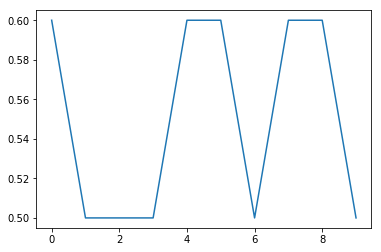

Prediction and reference:


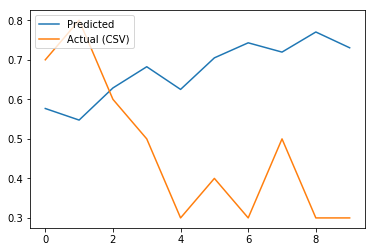

In [207]:
a = numpy.array([])
for i in range(0,look_back):
    a = numpy.append(a, testX[len(testX)-look_back*4-1][0][i])

print("Input:")
plt.plot(a)
plt.show()

predicted = numpy.array([])
for i in range(0,look_back):
    nextPredictionData = numpy.array([[a]])
    prediction = model.predict(nextPredictionData)
    predicted = numpy.append(predicted, prediction[0])
    a = numpy.delete(a,0,0)
    a = numpy.append(a, prediction[0])


reference = testX[len(testX)-31][0]
#print(predicted)
#print(reference)

print("Prediction and reference:")
plt.plot(predicted, label='Predicted')
plt.plot(reference, label='Actual (CSV)')
plt.legend(loc='upper left')
plt.show()
